In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns



### Context

Welcome to the **Hospitality** Analytics team! Our current initiative aims to enhance the booking management system for a chain of restaurants. Your expertise is requested to analyze the Restaurant Booking dataset, utilizing boosting algorithms to predict booking statuses and understand customer behaviors. This task will support strategic decision-making to optimize booking operations and enhance customer satisfaction.

### Dataset Description

The dataset you will analyze contains a variety of attributes related to restaurant bookings. These details offer insights into customer preferences, booking patterns, and cancellation trends. Each booking record is characterized by several features:

### Booking Attributes:
- **id:** Unique identifier for each booking.
- **no_of_adults:** Number of adults per booking.
- **no_of_children:** Number of children per booking.
- **no_of_weekend_nights:** Number of weekend nights booked.
- **no_of_week_nights:** Number of weekday nights booked.
- **type_of_meal_plan:** Type of meal plan selected (e.g., bed and breakfast, all-inclusive).
- **required_car_parking_space:** Indicates if a parking space was required.
- **room_type_reserved:** Type of room reserved.
- **lead_time:** Number of days between the booking date and the arrival date.
- **arrival_year, arrival_month, arrival_date:** Date details for when the booking is scheduled.
- **market_segment_type:** The market segment from which the booking originated.
- **repeated_guest:** Flag indicating if the guest has booked before.
- **no_of_previous_cancellations:** Number of prior cancellations by the guest.
- **no_of_previous_bookings_not_canceled:** Number of previous bookings not canceled by the guest.
- **avg_price_per_room:** Average price per room type.
- **no_of_special_requests:** Number of special requests made by the guest.
- **booking_status:** Status of the booking ( confirmed = 0, canceled = 1).

Your objective is to use boosting techniques to predict the 'booking_status' and analyze factors that influence booking behaviors. This analysis will help in identifying key trends that could influence policy adjustments, promotional strategies, and operational improvements.

In [130]:
df = pd.read_csv("./../data/booking.csv")
df.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


### Q1. Dataset filter bookings

In [11]:
cond = (df['no_of_adults'] == 0) & (df['no_of_children'] == 0)
len(df[cond])

16

### Q2. Bookings per month

Text(0.5, 1.0, 'confirmed')

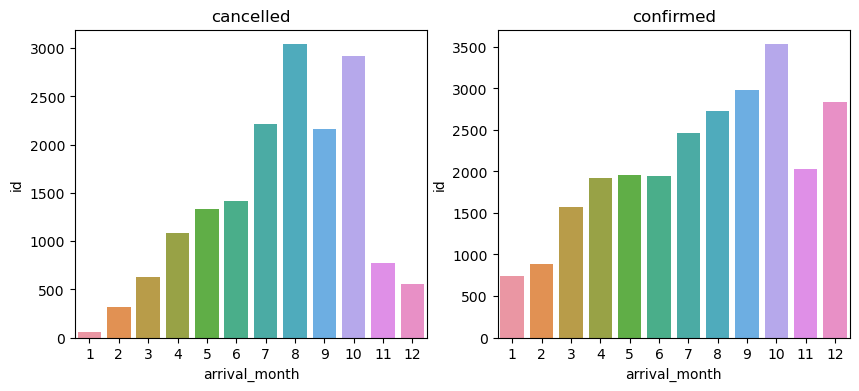

In [59]:
df1 = df.groupby(['arrival_month', 'booking_status']).agg('count').reset_index()[['arrival_month','booking_status', 'id']]
cancelled = df1[df1['booking_status'] == 1]
confirmed = df1[df1['booking_status'] == 0]

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('cancelled')
ax1 = sns.barplot(x = 'arrival_month', y='id', data=cancelled, errorbar=None)
plt.subplot(122)
ax2 = sns.barplot(x = 'arrival_month', y='id', data=confirmed, errorbar=None)
plt.title('confirmed')


<Axes: xlabel='arrival_month'>

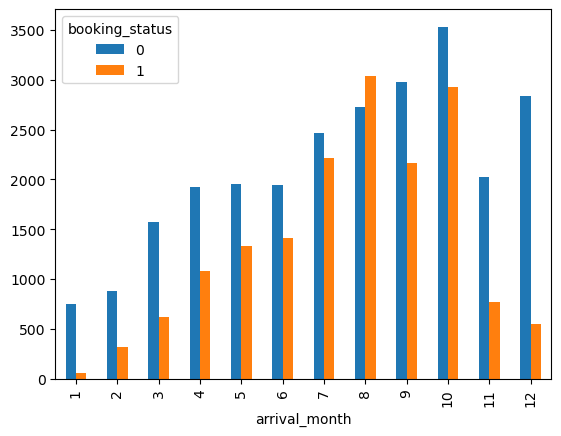

In [65]:
df.pivot_table(index='arrival_month', columns='booking_status', aggfunc='size').plot(kind='bar')

In [71]:
def process_arrival_date (col):
    return pd.to_datetime(df[col])

In [131]:
df = df.rename(columns={'arrival_year' :'year', 'arrival_month': 'month', 'arrival_date': 'day'})
df['date'] = pd.to_datetime(df[['day', 'month', 'year']], errors='coerce')
df = df.drop(columns=['day', 'month', 'year'])
df = df.dropna(axis=0)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['week'] = df.date.dt.week
df['day'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['quarter'] = df.date.dt.quarter
df['dayofyear'] = df.date.dt.dayofyear
df = df.drop(columns=['date'])

In [138]:
df.isna().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
date                                    0
dtype: int64

C:\Users\Upendra\AppData\Local\Temp\ipykernel_2272\2373740209.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


In [143]:
df.isna().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
year                                    0
month                                   0
week                                    0
day                                     0
dayofweek                               0
quarter                                 0
dayofyear                               0
dtype: int64

In [146]:
import numpy as np  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import accuracy_score  

df = pd.read_csv("./../data/booking.csv")
X = df.loc[:, df.columns!= 'booking_status']
y = df.loc[:, 'booking_status']

# Initialize weights  
weights = np.ones(len(X)) / len(X)  

# Train first weak learner  
dt1 = DecisionTreeClassifier(random_state=10, max_depth=1)  
dt1.fit(X, y)  
y_pred_1 = dt1.predict(X)  

# Update weights function  
def update_weights(y, y_pred, weights):  
    for i in range(len(weights)):  
        if y[i] != y_pred[i]:  
            weights[i] *= 1.5  # Increase the weight for misclassified instances  
        else:  
            weights[i] *= 0.5  # Decrease the weight for correctly classified instances  
    return weights / np.sum(weights)  # Normalize the weights  

# Apply first learner and update weights  
weights = update_weights(y, y_pred_1, weights)  

# Train second weak learner  
dt2 = DecisionTreeClassifier(random_state=10, max_depth=1)  
dt2.fit(X, y, sample_weight= weights)   # Utilize updated weights for learning for this sample_weight is used.
y_pred_2 = dt2.predict(X)  

# Combine the weak learners' predictions  
# Assuming a simple average for combination  
final_prediction = np.round((y_pred_1 + y_pred_2) / 2.0).astype(int)  

# Calculate the accuracy  
final_accuracy = accuracy_score(y, final_prediction)  
print(f"Final combined prediction accuracy: {final_accuracy*100}")

Final combined prediction accuracy: 71.40380047505938


In [156]:
def get_results():
    cm = confusion_matrix(y_pred, y_test)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    print(classification_report(y_pred, y_test))

    df1 = pd.DataFrame()
    df1['feature_importances_'] = gbclf.feature_importances_
    df1['feature_names_in_'] = gbclf.feature_names_in_ 
    df1 = df1.sort_values('feature_importances_', ascending=False)
    ax = sns.barplot(x='feature_names_in_', y='feature_importances_', data =df1)
    plt.xticks(rotation=90)
    plt.show()

0.8042755344418052


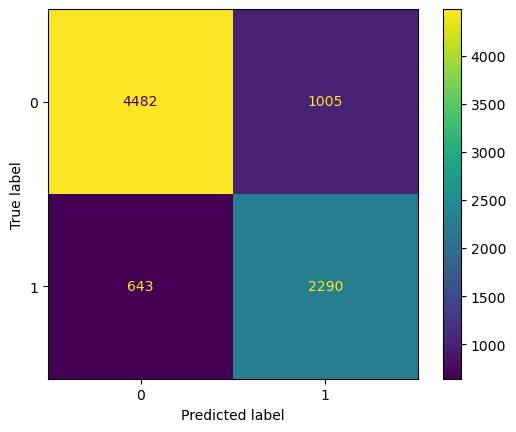

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      5487
           1       0.69      0.78      0.74      2933

    accuracy                           0.80      8420
   macro avg       0.78      0.80      0.79      8420
weighted avg       0.81      0.80      0.81      8420



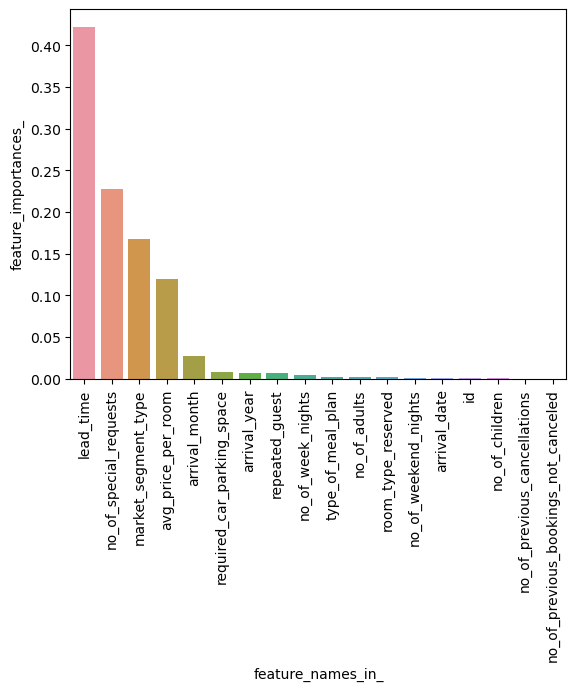

In [157]:
df = pd.read_csv("./../data/booking.csv")
X = df.loc[:, df.columns!= 'booking_status']
y = df.loc[:, 'booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
gbclf = GradientBoostingClassifier(random_state=10)
gbclf.fit(X_train, y_train)
y_pred = gbclf.predict(X_test)
print(gbclf.score(X_test, y_test ))
get_results()


In [162]:
def preprocessing_steps(df):
    df = df.rename(columns={'arrival_year' :'year', 'arrival_month': 'month', 'arrival_date': 'day'})
    df['date'] = pd.to_datetime(df[['day', 'month', 'year']], errors='coerce')
    df = df.drop(columns=['day', 'month', 'year'])
    df = df.dropna(axis=0)
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['week'] = df.date.dt.week
    df['day'] = df.date.dt.day
    df['dayofweek'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['dayofyear'] = df.date.dt.dayofyear
    df = df.drop(columns=['date'])
    return df

C:\Users\Upendra\AppData\Local\Temp\ipykernel_2272\1228440487.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


0.8128418549346017


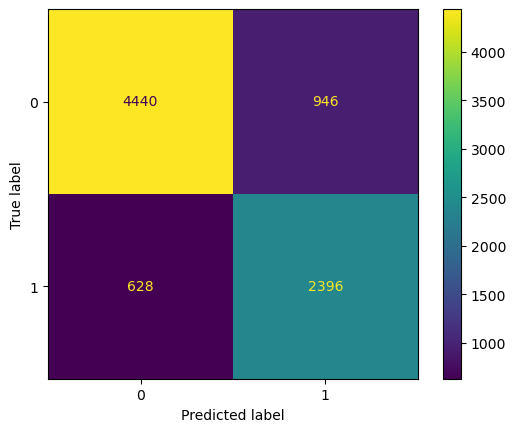

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5386
           1       0.72      0.79      0.75      3024

    accuracy                           0.81      8410
   macro avg       0.80      0.81      0.80      8410
weighted avg       0.82      0.81      0.81      8410



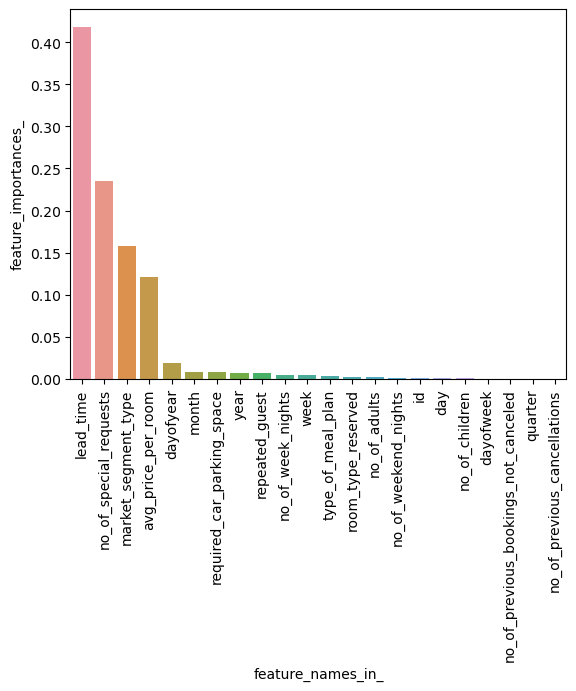

In [163]:
df = pd.read_csv("./../data/booking.csv")
df = preprocessing_steps(df)
X = df.loc[:, df.columns!= 'booking_status']
y = df.loc[:, 'booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
gbclf = GradientBoostingClassifier(random_state=10)
gbclf.fit(X_train, y_train)
y_pred = gbclf.predict(X_test)
print(gbclf.score(X_test, y_test ))
get_results()


# Q2. Shrinkage Boosting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)


In [12]:
gbc = GradientBoostingClassifier(random_state=10)

In [13]:
params = {'learning_rate':[0.1, 0.05, 0.01, 0.005, 0.001]}

kfold = KFold(n_splits=5, random_state=10, shuffle=True)
gscv = GridSearchCV(gbc, param_grid=params, verbose=6, cv=kfold,  return_train_score=True , scoring='accuracy')

In [14]:
cv_results = gscv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END learning_rate=0.1;, score=(train=0.810, test=0.816) total time=   3.7s
[CV 2/5] END learning_rate=0.1;, score=(train=0.813, test=0.811) total time=   5.5s
[CV 3/5] END learning_rate=0.1;, score=(train=0.813, test=0.810) total time=   5.5s
[CV 4/5] END learning_rate=0.1;, score=(train=0.814, test=0.806) total time=   5.7s
[CV 5/5] END learning_rate=0.1;, score=(train=0.816, test=0.802) total time=   5.6s
[CV 1/5] END learning_rate=0.05;, score=(train=0.804, test=0.811) total time=   5.6s
[CV 2/5] END learning_rate=0.05;, score=(train=0.806, test=0.806) total time=   5.7s
[CV 3/5] END learning_rate=0.05;, score=(train=0.806, test=0.803) total time=   5.8s
[CV 4/5] END learning_rate=0.05;, score=(train=0.806, test=0.802) total time=   5.9s
[CV 5/5] END learning_rate=0.05;, score=(train=0.807, test=0.799) total time=   5.7s
[CV 1/5] END learning_rate=0.01;, score=(train=0.770, test=0.772) total time=   6.4s
[CV 2/5] E

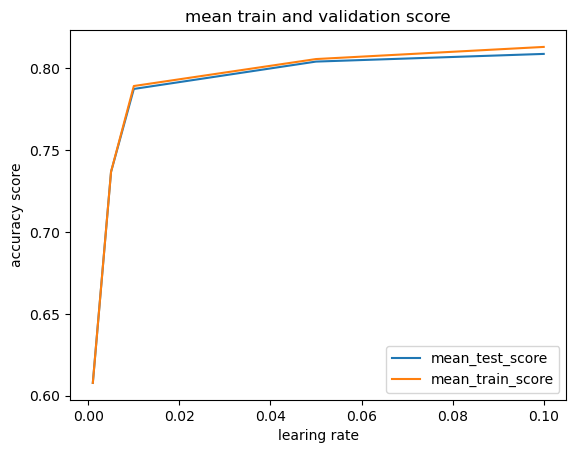

In [15]:
sns.lineplot(y=cv_results.cv_results_['mean_test_score'], x = [0.1, 0.05, 0.01, 0.005, 0.001],  label = 'mean_test_score')
sns.lineplot(y = cv_results.cv_results_['mean_train_score'], x = [0.1, 0.05, 0.01, 0.005, 0.001], label = 'mean_train_score')
plt.legend()
plt.title('mean train and validation score')
plt.xlabel('learing rate')
plt.ylabel('accuracy score')
plt.show()


# Q3. Boosting Max Depth


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
gbc = GradientBoostingClassifier(random_state=10)
params = {'max_depth':range(1, 16)}
kfold = KFold(n_splits=3, random_state=10, shuffle=True)
gscv = GridSearchCV(gbc, param_grid=params, verbose=6, cv=kfold,  return_train_score=True , scoring='accuracy', n_jobs=-1)
cv_results = gscv.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


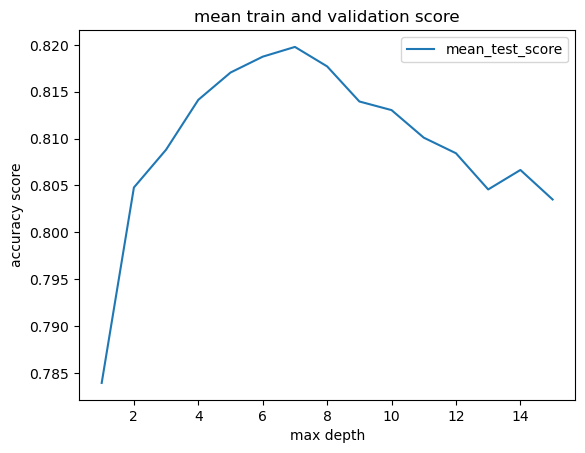

In [17]:
sns.lineplot(y=cv_results.cv_results_['mean_test_score'], x = range(1, 16),  label = 'mean_test_score', markers='o')
#sns.lineplot(y = cv_results.cv_results_['mean_train_score'], x = range(1, 16), label = 'mean_train_score')
plt.legend()
plt.title('mean train and validation score')
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.show()


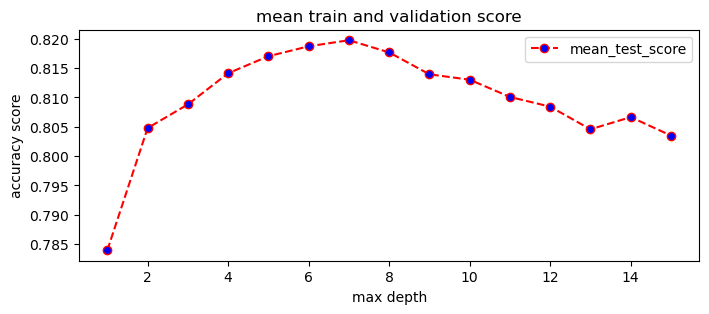

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 16), cv_results.cv_results_['mean_test_score'], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', label= 'mean_test_score')
#plt.plot(range(1, 16), cv_results.cv_results_['mean_train_score'], color='blue', linestyle='dashed', marker='o',
#         markerfacecolor='blue', label= 'mean_train_score')

plt.legend()
plt.title('mean train and validation score')
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.show()
 

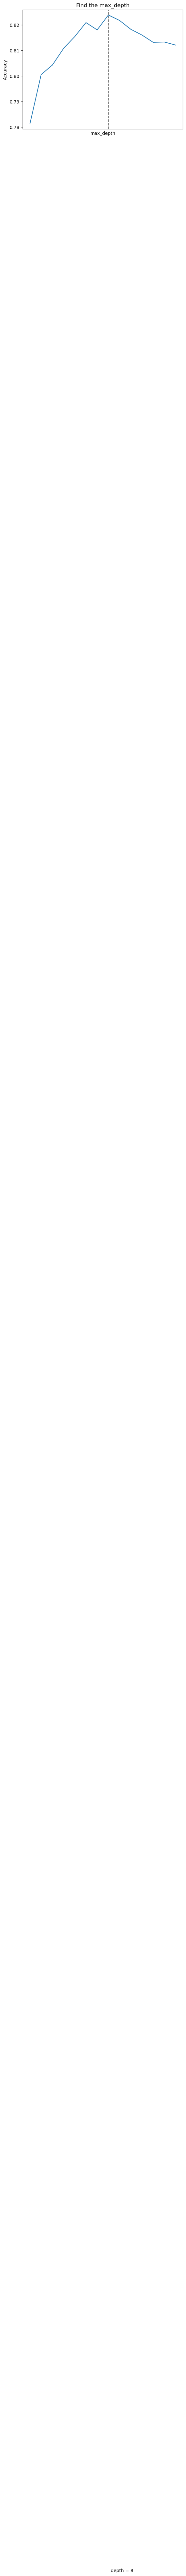

In [19]:
acc = []
dep = []
best_depth = 0
best_acc = 0

# Train a model for each depth and evaluate its accuracy
for d in range(1,15):
    model = GradientBoostingClassifier(max_depth= d , random_state=10)
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    acc.append(accuracy)
    dep.append(dep)

    if accuracy > best_acc:
      best_acc = accuracy
      best_depth = d




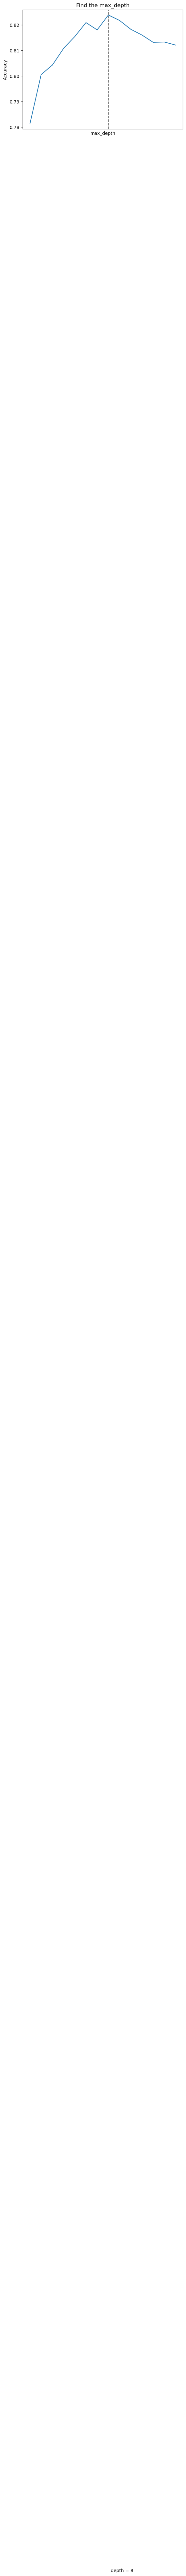

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the line plot
sns.lineplot(x=range(1, 15), y=acc)

# Remove x-ticks
plt.xticks([])

# Add x-axis label
plt.title("Find the max_depth")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


# Annotate the line at x = 8
highest_acc = acc[best_depth - 1]  # Adjusting for zero-based indexing
plt.axvline(x=best_depth , color='gray', linestyle='--')
plt.text(best_depth   + 0.2, highest_acc -1 , f"depth = {best_depth}", verticalalignment='center')

# Show the plot
plt.show()

# Q4. Scaling in Boosting

In [31]:
df = pd.read_csv("./../data/booking.csv")
df.head()

X = df.loc[:, df.columns!= 'booking_status']
y = df.loc[:, 'booking_status']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [33]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

In [34]:
gbc1 = GradientBoostingClassifier(random_state=10)
gbc1.fit(X_train_scaled, y_train)
y_pred = gbc1.predict(X_test_scaled)
accuracy_score(y_pred, y_test)

0.8042755344418052

In [24]:
gbc2 = GradientBoostingClassifier(random_state=10)
gbc2.fit(X_train, y_train)
y_pred = gbc2.predict(X_test)
accuracy_score(y_pred, y_test)

0.8042755344418052

In [25]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are already defined
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

model_with_scaled = GradientBoostingClassifier(random_state=10)
model_with_scaled.fit(X_train_scaled, y_train)
accuracy_with_scaled = accuracy_score(y_test, model_with_scaled.predict(X_test_scaled))

model_without_scaled = GradientBoostingClassifier(random_state=10)
model_without_scaled.fit(X_train, y_train)
accuracy_without_scaled = accuracy_score(y_test, model_without_scaled.predict(X_test))

print(f"accuracy_with_scaled = {accuracy_with_scaled}")
print(f"accuracy_without_scaled = {accuracy_without_scaled}")

print(f"Difference = {accuracy_with_scaled - accuracy_without_scaled}")


accuracy_with_scaled = 0.8042755344418052
accuracy_without_scaled = 0.8042755344418052
Difference = 0.0


# Q5. Grid Search Boosting

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
gbc = GradientBoostingClassifier(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8],
    'min_samples_split': [2, 4, 6]
}
kfold = KFold(n_splits=2, random_state=10, shuffle=True)
gscv = GridSearchCV(gbc, param_grid=param_grid, verbose=6, cv=kfold,  return_train_score=True , scoring='accuracy', n_jobs=-1)
cv_results = gscv.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


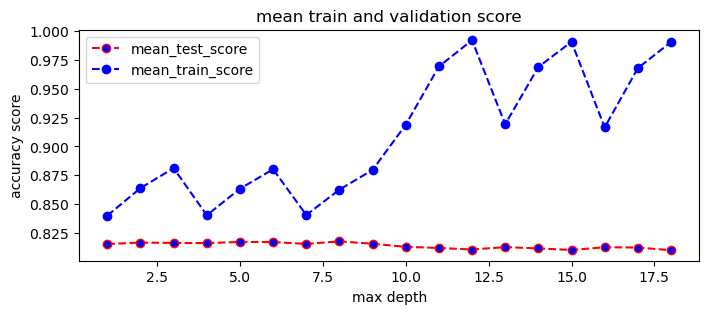

In [27]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 19), cv_results.cv_results_['mean_test_score'], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', label= 'mean_test_score')
plt.plot(range(1, 19), cv_results.cv_results_['mean_train_score'], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', label= 'mean_train_score')

plt.legend()
plt.title('mean train and validation score')
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.show()

In [28]:
cv_results.best_estimator_

GradientBoostingClassifier(max_depth=5, min_samples_split=6, n_estimators=200,
                           random_state=10)

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

# Defining the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8],
    'min_samples_split': [2, 4, 6]
}

# Initializing the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=10)

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(gbm, param_grid, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Printing the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

result = grid_search.cv_results_
for i in range(len(result["params"])):
  print(f"Parameters:{result['params'][i]} Mean_score: {result['mean_test_score'][i]} Rank: {result['rank_test_score'][i]}")

print(grid_search.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.8193290109227566
Parameters:{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100} Mean_score: 0.8155285429094269 Rank: 14
Parameters:{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200} Mean_score: 0.8184976499492972 Rank: 6
Parameters:{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300} Mean_score: 0.8193290109227566 Rank: 1
Parameters:{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 100} Mean_score: 0.8153800648123027 Rank: 15
Parameters:{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200} Mean_score: 0.8186460777955512 Rank: 5
Parameters:{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 300} Mean_score: 0.8188242197747085 Rank: 3
Parameters:{'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 100} Mean_score: 0.815914503973688 Rank: 12
Parameters:{'max_depth': 5

In [42]:
result = grid_search.cv_results_
for i in range(len(result["params"])):
    if (result['rank_test_score'][i] <=5):
      print(f"Parameters:{result['params'][i]} Mean_score: {result['mean_test_score'][i]} Rank: {result['rank_test_score'][i]}")


Parameters:{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300} Mean_score: 0.8193290109227566 Rank: 1
Parameters:{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200} Mean_score: 0.8186460777955512 Rank: 5
Parameters:{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 300} Mean_score: 0.8188242197747085 Rank: 3
Parameters:{'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 200} Mean_score: 0.8189726872927023 Rank: 2
Parameters:{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100} Mean_score: 0.8186757760597588 Rank: 4


In [48]:
gbm1 = GradientBoostingClassifier(random_state=10, max_depth = 5, min_samples_split = 2, n_estimators = 300)
gbm2 = GradientBoostingClassifier(random_state=10, max_depth = 5, min_samples_split = 4, n_estimators = 200)
gbm3 = GradientBoostingClassifier(random_state=10, max_depth = 5, min_samples_split = 4, n_estimators = 300)
gbm4 = GradientBoostingClassifier(random_state=10, max_depth = 5, min_samples_split = 6, n_estimators = 200)
gbm5 = GradientBoostingClassifier(random_state=10, max_depth = 8, min_samples_split = 2, n_estimators = 100)

In [49]:
for model in [gbm1, gbm2, gbm3, gbm4, gbm5]:
    model.fit(X_train, y_train)

In [53]:
for model in [gbm1, gbm2, gbm3, gbm4, gbm5]:
    print(accuracy_score(y_test, model.predict(X_test)))

0.8214964370546318
0.8203087885985748
0.8242280285035629
0.8207838479809976
0.8238717339667458


# Q7. Outliers in Boosting

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
# 1st and 99th percentiles
per_0 = np.percentile(X_train.lead_time, 1, axis=0)
per_99 = np.percentile(X_train.lead_time, 99)


In [83]:
len(X_train[X_train.lead_time > per_99]) - len(X_train[X_train.lead_time < per_0])

334

In [84]:
X_train

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
6483,6483,2,0,0,2,0,0,4,24,2018,7,1,1,0,0,0,142.00,0
10149,10149,1,0,0,2,0,0,0,10,2018,10,14,0,0,0,0,119.00,0
12544,12544,1,0,1,2,0,0,0,32,2018,7,18,0,0,0,0,85.00,0
41755,41755,1,0,2,3,0,0,1,6,2018,5,6,3,0,0,0,110.00,0
35298,35298,2,1,1,2,0,0,0,44,2018,10,31,1,0,0,0,107.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,40059,2,0,1,2,0,0,1,32,2018,2,11,1,0,0,0,64.22,1
28017,28017,1,0,0,1,0,0,0,0,2018,10,13,0,0,0,0,140.00,0
29199,29199,2,1,1,0,0,0,0,208,2018,8,21,1,0,0,0,112.50,3
40061,40061,2,0,2,2,2,0,0,273,2017,7,17,1,0,0,0,80.00,0


# Q8. Outliers in Boosting II

In [87]:
X_train_oRem = X_train[(X_train.lead_time < per_99) & (X_train.lead_time > per_0)] 
X_train_oRem

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
6483,6483,2,0,0,2,0,0,4,24,2018,7,1,1,0,0,0,142.00,0
10149,10149,1,0,0,2,0,0,0,10,2018,10,14,0,0,0,0,119.00,0
12544,12544,1,0,1,2,0,0,0,32,2018,7,18,0,0,0,0,85.00,0
41755,41755,1,0,2,3,0,0,1,6,2018,5,6,3,0,0,0,110.00,0
35298,35298,2,1,1,2,0,0,0,44,2018,10,31,1,0,0,0,107.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,9372,2,0,0,4,0,0,1,92,2018,8,2,1,0,0,0,150.30,1
40059,40059,2,0,1,2,0,0,1,32,2018,2,11,1,0,0,0,64.22,1
29199,29199,2,1,1,0,0,0,0,208,2018,8,21,1,0,0,0,112.50,3
40061,40061,2,0,2,2,2,0,0,273,2017,7,17,1,0,0,0,80.00,0


In [89]:
y_train_oRem = y_train[(X_train.lead_time < per_99) & (X_train.lead_time > per_0)] 
y_train_oRem

6483     0
10149    0
12544    0
41755    0
35298    0
        ..
9372     1
40059    0
29199    0
40061    1
17673    0
Name: booking_status, Length: 32674, dtype: int64

In [81]:
gbc1 = GradientBoostingClassifier(random_state=10)
gbc1.fit(X_train, y_train)
print(accuracy_score(y_test, gbc1.predict(X_test)))

0.8042755344418052


In [91]:
gbc2 = GradientBoostingClassifier(random_state=10)
gbc2.fit(X_train_oRem, y_train_oRem)
print(accuracy_score(y_test, gbc2.predict(X_test)))

0.8067695961995249


# Q9. Loss in Boosting

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)



In [103]:
# train with default loss funtion
gbc = GradientBoostingClassifier(random_state=10)
gbc.fit(X_train, y_train)
print(f'default - log loss : {accuracy_score(y_test, gbc.predict(X_test))}')

default - log loss : 0.8042755344418052


In [105]:
# train with default loss funtion
gbc = GradientBoostingClassifier(random_state=10, loss='exponential')
gbc.fit(X_train, y_train)
print(f'with - exponential : {accuracy_score(y_test, gbc.predict(X_test))}')

with - exponential : 0.8057007125890736


# Q10. Estimators in Boosting


In [119]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

n_estimators_list = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000]
test_accuracies = []
train_accuracies = []

for n_estimators in n_estimators_list:
    # Initializing the Gradient Boosting Classifier
    model = GradientBoostingClassifier(random_state=10, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    train_accuracies.append(train_accuracy)
    
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    test_accuracies.append(test_accuracy)
    print(f'{n_estimators}  train accuracy {train_accuracy}: test accuracy = {test_accuracy}')

1  train accuracy 0.6078087885985748: test accuracy = 0.6086698337292161
5  train accuracy 0.7369061757719715: test accuracy = 0.7355106888361045
10  train accuracy 0.793230403800475: test accuracy = 0.7858669833729216
20  train accuracy 0.795665083135392: test accuracy = 0.7891923990498813
50  train accuracy 0.806918052256532: test accuracy = 0.8002375296912114
100  train accuracy 0.8133313539192399: test accuracy = 0.8042755344418052
200  train accuracy 0.8199821852731591: test accuracy = 0.8111638954869359
300  train accuracy 0.8248812351543943: test accuracy = 0.8157957244655581
500  train accuracy 0.8322149643705463: test accuracy = 0.8193586698337292
1000  train accuracy 0.8470902612826603: test accuracy = 0.8258907363420428


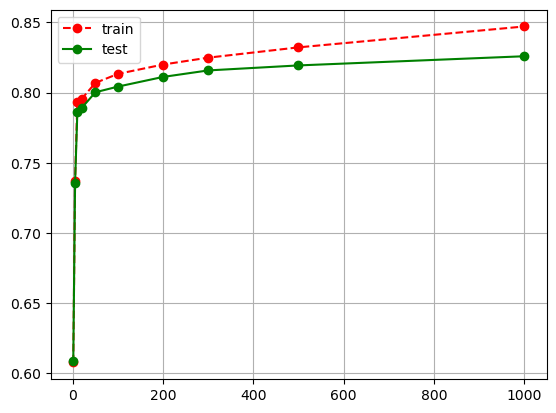

In [128]:
plt.plot(n_estimators_list, train_accuracies, label='train', color='red', marker='o', linestyle='dashed')
plt.plot(n_estimators_list, test_accuracies, label='test', color='green', marker='o')
plt.legend()
plt.grid(True)
plt.show()


Accuracy with 1 estimators: 0.6086698337292161
Accuracy with 5 estimators: 0.7355106888361045
Accuracy with 10 estimators: 0.7858669833729216
Accuracy with 20 estimators: 0.7891923990498813
Accuracy with 50 estimators: 0.8002375296912114
Accuracy with 100 estimators: 0.8042755344418052
Accuracy with 200 estimators: 0.8111638954869359
Accuracy with 300 estimators: 0.8157957244655581
Accuracy with 500 estimators: 0.8193586698337292
Accuracy with 1000 estimators: 0.8258907363420428


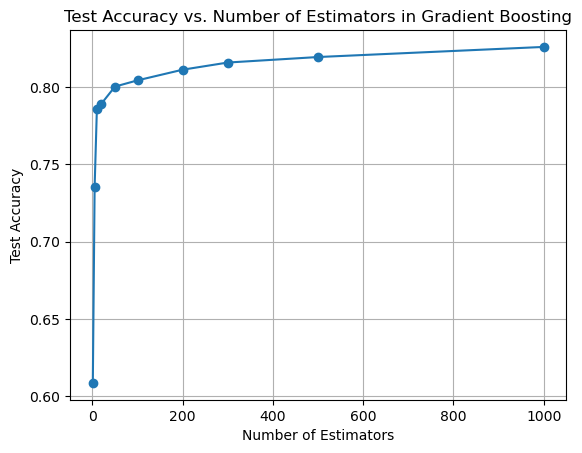

In [118]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Initialize the number of estimators
n_estimators_list = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000]
test_accuracies = []

# Train and evaluate the model with different numbers of weak learners
for n_estimators in n_estimators_list:
    clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=10)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    test_accuracies.append(accuracy)
    print(f"Accuracy with {n_estimators} estimators: {accuracy}")

# Plotting the test accuracies
plt.plot(n_estimators_list, test_accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Estimators in Gradient Boosting')
plt.grid(True)
plt.show()